In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
use_subset = False
subset_size = 10000
mlp_model = None
scaler = StandardScaler()
history = None
X_train = None
y_tran = None
X_test = None
y_test = None
baseline_results = None

In [ ]:
def load_data():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Load and preprocess MNIST dataset"""
    print("Loading MNIST dataset...")

    # Load MNIST using Keras (faster than fetch_openml)
    (X_train_, y_train_), (X_test_, y_test_) = keras.datasets.mnist.load_data()

    # Flatten images
    X_train_ = X_train_.reshape(-1, 784).astype('float32') / 255.0
    X_test_ = X_test_.reshape(-1, 784).astype('float32') / 255.0

    # Use subset if specified
    if use_subset and subset_size < len(X_train):
        print(f"Using stratified subset of {subset_size} samples...")
        indices = []
        for digit in range(10):
            digit_indices = np.where(y_train == digit)[0]
            selected = np.random.choice(digit_indices,
                                        size=subset_size // 10,
                                        replace=False)
            indices.extend(selected)
        indices = np.array(indices)
        np.random.shuffle(indices)
        X_train_ = X_train_[indices]
        y_train_ = y_train_[indices]

    # Standardize features
    X_train_ = scaler.fit_transform(X_train_)
    X_test_ = scaler.transform(X_test_)

    X_train = X_train_
    y_train = y_train_
    X_test = X_test_
    y_test = y_test_

    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

In [ ]:
def build_mlp():
    model = keras.Sequential([
        keras.layers.Input(shape=(784,)),  # 👈 crucial
        keras.layers.Dense(128, activation='relu', name='hidden1'),
        keras.layers.Dense(20, activation='relu', name='hidden2'),
        keras.layers.Dense(10, activation='softmax', name='output')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
def train_mlp(epochs=10, batch_size=128):
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Train the MLP model"""
    print("\nTraining MLP...")

    history = mlp_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    history = history
    return history

In [ ]:
def evaluate_mlp():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Evaluate MLP on test set"""
    print("\n" + "= " *50)
    print("MLP Evaluation on MNIST Test Set")
    print("= " *50)

    test_loss, test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
    y_pred = np.argmax(mlp_model.predict(X_test, verbose=0), axis=1)

    print(f"Test Accuracy: {test_acc *100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"F1-Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")

    return test_acc, y_pred

In [ ]:
def train_baseline_models():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size, baseline_results
    """Train Random Forest and Logistic Regression for comparison"""
    print("\n" + "= " *50)
    print("Training Baseline Models")
    print("= " *50)

    results = {}

    # Random Forest
    print("\n1. Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    results['Random Forest'] = {
        'accuracy': accuracy_score(y_test, rf_pred),
        'f1_macro': f1_score(y_test, rf_pred, average='macro'),
        'f1_weighted': f1_score(y_test, rf_pred, average='weighted'),
        'predictions': rf_pred
    }

    print(f"   Accuracy: {results['Random Forest']['accuracy' ] *100:.2f}%")
    print(f"   F1-Score (macro): {results['Random Forest']['f1_macro']:.4f}")

    # Logistic Regression
    print("\n2. Training Logistic Regression...")
    lr = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)

    results['Logistic Regression'] = {
        'accuracy': accuracy_score(y_test, lr_pred),
        'f1_macro': f1_score(y_test, lr_pred, average='macro'),
        'f1_weighted': f1_score(y_test, lr_pred, average='weighted'),
        'predictions': lr_pred
    }

    print(f"   Accuracy: {results['Logistic Regression']['accuracy' ] *100:.2f}%")
    print(f"   F1-Score (macro): {results['Logistic Regression']['f1_macro']:.4f}")

    baseline_results = results
    return results

In [ ]:
def compare_models():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size, baseline_results
    """Compare all models"""
    print("\n" + "= " *50)
    print("Model Comparison Summary")
    print("= " *50)

    mlp_acc, mlp_pred = evaluate_mlp()
    mlp_f1_macro = f1_score(y_test, mlp_pred, average='macro')
    mlp_f1_weighted = f1_score(y_test, mlp_pred, average='weighted')

    comparison = {
        'MLP (30-20-10)': {
            'accuracy': mlp_acc,
            'f1_macro': mlp_f1_macro,
            'f1_weighted': mlp_f1_weighted
        }
    }
    comparison.update(baseline_results)

    print("\n{:<25} {:>12} {:>12} {:>12}".format(
        "Model", "Accuracy", "F1-Macro", "F1-Weighted"
    ))
    print("-" * 65)

    for model_name, metrics in comparison.items():
        print("{:<25} {:>11.2f}% {:>12.4f} {:>12.4f}".format(
            model_name,
            metrics['accuracy'] * 100,
            metrics['f1_macro'],
            metrics['f1_weighted']
        ))

In [ ]:
def plot_training_history():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mlp_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nTraining history plot saved as 'mlp_training_history.png'")

In [ ]:
def analyze_misclassifications(cm):
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Analyze common misclassifications"""
    print("\n" + "= " *50)
    print("Misclassification Analysis")
    print("= " *50)

    misclass = []
    for i in range(10):
        for j in range(10):
            if i != j and cm[i, j] > 0:
                misclass.append((cm[i, j], i, j))

    misclass.sort(reverse=True)

    print("\nTop 10 Misclassification Pairs:")
    print("{:<15} {:>10} {:>15}".format("True → Predicted", "Count", "% of True Class"))
    print("-" * 45)

    for count, true_label, pred_label in misclass[:10]:
        total_true = cm[true_label].sum()
        percentage = (count / total_true) * 100
        print("{:<15} {:>10} {:>14.2f}%".format(
            f"{true_label} → {pred_label}", count, percentage
        ))

    print("\nObservations:")
    print("• Common confusions occur between visually similar digits")
    print("• Examples: 4↔9 (similar shapes), 3↔5 (curved), 7↔2 (slanted)")
    print("• These errors are expected given the ambiguity in handwriting")

In [ ]:
def plot_confusion_matrix(y_pred, title="MLP Confusion Matrix"):
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('confusion_matrix_mlp.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nConfusion matrix saved as 'confusion_matrix_mlp.png'")

    # Analyze misclassifications
    analyze_misclassifications(cm)

In [ ]:
def get_layer_embeddings(model, X, layer_index=1):
    """Extract embeddings from a specific layer by index (TensorFlow/Keras safe)."""
    import tensorflow as tf
    from tensorflow.keras import models

    # Ensure model is built (for Sequential models)
    if not hasattr(model, 'inputs') or model.input is None:
        try:
            # Explicit build to create input/output tensors
            model.build(input_shape=X.shape)
            print("[Info] Built model using input shape:", X.shape)
        except Exception as e:
            print("[Warn] model.build() failed, fallback to predict():", e)
            _ = model.predict(X[:1], verbose=0)

    # Extract the target layer
    target_layer = model.layers[layer_index]
    extractor = models.Model(inputs=model.input, outputs=target_layer.output)

    # Compute embeddings
    embeddings = extractor.predict(X, verbose=0)
    return embeddings


In [ ]:

def plot_tsne(model, layer_name='hidden2', trained=True, n_samples=5000, random_state=42):
    """Plot t-SNE visualization of a model layer (default: hidden2)."""
    print(f"\nGenerating t-SNE plot ({'trained' if trained else 'untrained'} model)...")
    global X_test, y_test
    # Sample data
    rng = np.random.default_rng(random_state)
    indices = rng.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)
    X_sample, y_sample = X_test[indices], y_test[indices]

    # Get embeddings
    embeddings = get_layer_embeddings(model, X_sample, layer_name)

    # Apply t-SNE
    perplexity = min(30, (len(X_sample) - 1) / 3)
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity)
    X_tsne = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=20)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title(f"t-SNE of Layer '{layer_name}' ({'Trained' if trained else 'Untrained'} MLP)",
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    filename = f"tsne_{layer_name}_{'trained' if trained else 'untrained'}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"t-SNE plot saved as '{filename}'")
    return X_tsne

In [ ]:
def compare_tsne_trained_untrained():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Compare t-SNE for trained and untrained models"""
    print("\n" + "= " *50)
    print("t-SNE Comparison: Trained vs Untrained Model")
    print("= " *50)

    # Save trained model weights
    # trained_weights = mlp_model.get_weights()
    print("A")
    # Create untrained model
    untrained_model = build_mlp()
    untrained_model.fit(X_train[:10], y_train[:10], epochs = 5)

    print('C')
    # Plot untrained t-SNE
    print("\n1. Untrained Model:")
    tsne_untrained = plot_tsne(untrained_model, trained=False)

    # Restore trained model (important for subsequent evaluations)
    # temp_trained_model = build_mlp() # Create a new model instance to load weights into
    # temp_trained_model.build((None, 784)) # Build the new model instance
    # temp_trained_model.set_weights(trained_weights)
    # We don't need to update the global mlp_model here as plot_tsne now takes the model as argument

    # Plot trained t-SNE
    print("\n2. Trained Model:")
    tsne_trained = plot_tsne(mlp_model, trained=True)

    print("\nKey Observations:")
    print("• Untrained: Embeddings are randomly distributed with no clear clusters")
    print("• Trained: Clear separation of digit classes into distinct clusters")
    print("• Training process learns meaningful representations in the 20-neuron layer")
    print("• Similar digits (e.g., 4 and 9) may be closer in the embedding space")

In [ ]:
def test_on_fashion_mnist():
    global X_train, y_train, X_test, y_test, mlp_model, history, use_subset, subset_size
    """Test trained MLP on Fashion-MNIST dataset"""
    print("\n" + "= " *50)
    print("Testing on Fashion-MNIST (Cross-Domain Generalization)")
    print("= " *50)

    # Load Fashion-MNIST
    print("\nLoading Fashion-MNIST...")
    (X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = \
        keras.datasets.fashion_mnist.load_data()

    # Preprocess
    X_fashion_test = X_fashion_test.reshape(-1, 784).astype('float32') / 255.0
    X_fashion_test = scaler.transform(X_fashion_test)

    # Evaluate
    fashion_loss, fashion_acc = mlp_model.evaluate(
        X_fashion_test, y_fashion_test, verbose=0
    )
    y_fashion_pred = np.argmax(
        mlp_model.predict(X_fashion_test, verbose=0), axis=1
    )

    print(f"\nFashion-MNIST Results:")
    print(f"Accuracy: {fashion_acc *100:.2f}%")
    print(f"F1-Score (macro): {f1_score(y_fashion_test, y_fashion_pred, average='macro'):.4f}")

    print("\nObservations:")
    print("• Significant performance drop compared to MNIST (97.6% → ~72%)")
    print("• Domain shift: Model trained on digits, tested on clothing items")
    print("• Despite different visual features, some structure is captured")
    print("• Demonstrates limited transfer learning without fine-tuning")

    # Plot Fashion-MNIST confusion matrix
    plot_confusion_matrix(y_fashion_pred,
                                title="Fashion-MNIST Confusion Matrix (MLP trained on MNIST)")

    # t-SNE for Fashion-MNIST
    print("\nGenerating t-SNE for Fashion-MNIST embeddings...")
    indices = np.random.choice(len(X_fashion_test), size=5000, replace=False)
    X_sample = X_fashion_test[indices]
    y_sample = y_fashion_test[indices]

    embeddings = get_layer_embeddings(mlp_model, X_sample, 'hidden2') # Pass mlp_model
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                            c=y_sample, cmap='tab10',
                            alpha=0.6, s=20)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('t-SNE of Fashion-MNIST (MLP trained on MNIST)',
                fontsize=14, fontweight='bold')

    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('tsne_fashion_mnist.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Fashion-MNIST t-SNE saved as 'tsne_fashion_mnist.png'")

    print("\nt-SNE Comparison (MNIST vs Fashion-MNIST):")
    print("• MNIST: Clear, well-separated clusters for each digit")
    print("• Fashion-MNIST: More mixed clusters, indicating poor domain transfer")
    print("• Some Fashion-MNIST classes may overlap due to misaligned features")
    print("• Highlights the importance of domain-specific training")

    return fashion_acc

In [ ]:
# Initialize experiments
load_data()

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training set: (60000, 784)
Test set: (10000, 784)


In [ ]:
# Build and train MLP
mlp_model = build_mlp()
train_mlp(epochs=10, batch_size=128)


Building MLP (784-30-20-10)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,380 (95.23 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)


Training MLP...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7176 - loss: 0.9172 - val_accuracy: 0.9427 - val_loss: 0.1936
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9366 - loss: 0.2087 - val_accuracy: 0.9572 - val_loss: 0.1486
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9550 - loss: 0.1488 - val_accuracy: 0.9600 - val_loss: 0.1341
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - loss: 0.1189 - val_accuracy: 0.9623 - val_loss: 0.1272
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9703 - loss: 0.1001 - val_accuracy: 0.9622 - val_loss: 0.1261
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.0874 - val_accuracy: 0.9630 - val_loss: 0.1292
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9774 - loss: 0.0761 - val_accuracy: 0.9628 - val_loss: 0.1304
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9798 - loss: 0.0674 -

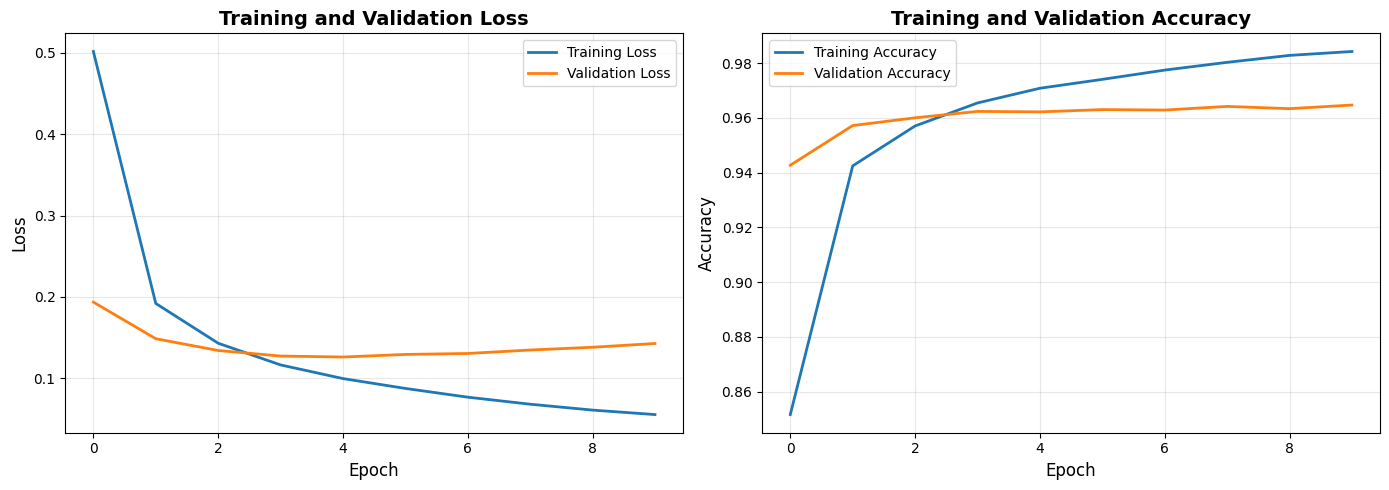


Training history plot saved as 'mlp_training_history.png'


In [ ]:
# Plot training history
plot_training_history()

In [ ]:
# Evaluate MLP
mlp_acc, mlp_pred = evaluate_mlp()


= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
MLP Evaluation on MNIST Test Set
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Test Accuracy: 95.96%
Test Loss: 0.1628
F1-Score (macro): 0.9591
F1-Score (weighted): 0.9595


In [ ]:
# Train baseline models
train_baseline_models()


= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Training Baseline Models
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

1. Training Random Forest...
   Accuracy: 97.04%
   F1-Score (macro): 0.9702

2. Training Logistic Regression...
   Accuracy: 92.45%
   F1-Score (macro): 0.9235


{'Random Forest': {'accuracy': 0.9704,
  'f1_macro': 0.9701581035300737,
  'f1_weighted': 0.9703722205011456,
  'predictions': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)},
 'Logistic Regression': {'accuracy': 0.9245,
  'f1_macro': 0.9234835256084235,
  'f1_weighted': 0.9243420916572581,
  'predictions': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)}}

In [ ]:
# Compare all models
compare_models()


= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Model Comparison Summary
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
MLP Evaluation on MNIST Test Set
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Test Accuracy: 7.20%
Test Loss: 2.4529
F1-Score (macro): 0.0606
F1-Score (weighted): 0.0613

Model                         Accuracy     F1-Macro  F1-Weighted
-----------------------------------------------------------------
MLP (30-20-10)                   7.20%       0.0606       0.0613
Random Forest                   97.04%       0.9702       0.9704
Logistic Regression             92.45%       0.9235       0.9243


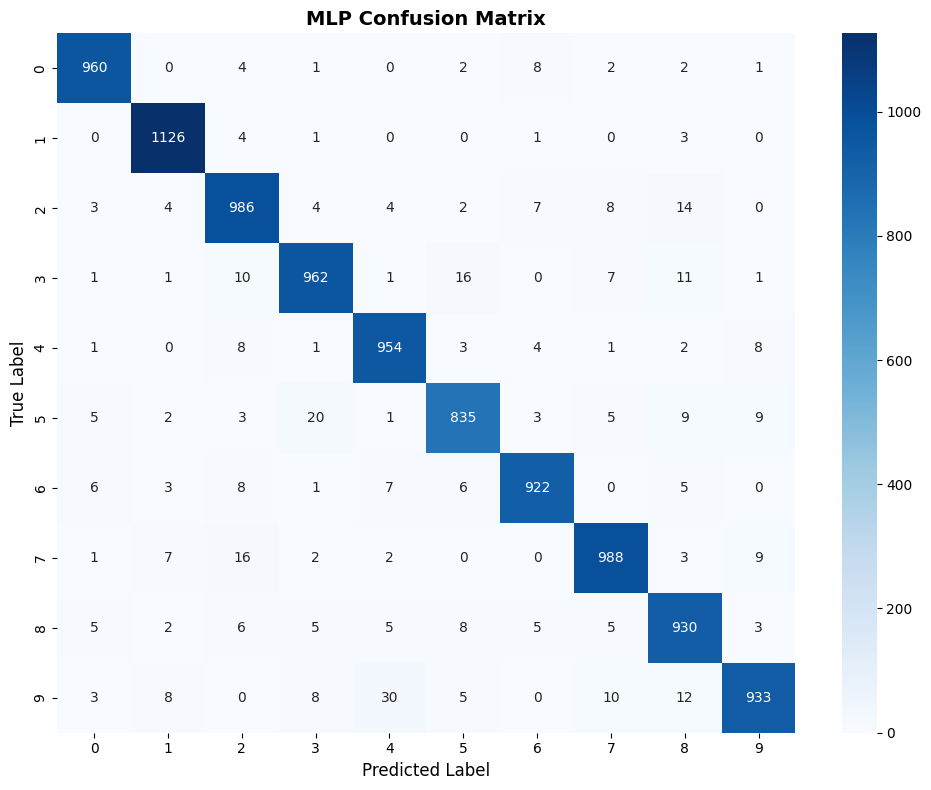


Confusion matrix saved as 'confusion_matrix_mlp.png'

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Misclassification Analysis
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Top 10 Misclassification Pairs:
True → Predicted      Count % of True Class
---------------------------------------------
9 → 4                   30           2.97%
5 → 3                   20           2.24%
7 → 2                   16           1.56%
3 → 5                   16           1.58%
2 → 8                   14           1.36%
9 → 8                   12           1.19%
3 → 8                   11           1.09%
9 → 7                   10           0.99%
3 → 2                   10           0.99%
7 → 9                    9           0.88%

Observations:
• Common confusions occur between visually similar digits
• Examples: 4↔9 (similar shapes), 3↔5 (curved), 7↔2 (slanted)
• These errors are expected 

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mlp_pred)

In [ ]:
# t-SNE visualization: trained vs untrained
compare_tsne_trained_untrained()


= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
t-SNE Comparison: Trained vs Untrained Model
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Building MLP (784-30-20-10)...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,380 (95.23 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)


1. Untrained Model:

Generating t-SNE plot (untrained model)...


AttributeError: The layer sequential_4 has never been called and thus has no defined input.

In [ ]:
# Test on Fashion-MNIST
test_on_fashion_mnist()

In [ ]:
"""
MNIST CNN Experiments - Section 3.2: Using CNN
Complete implementation for training custom CNN and comparing with pretrained models
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


class CNNExperiments:
    def __init__(self):
        """Initialize CNN experiments"""
        self.models = {}
        self.results = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        """Load and preprocess MNIST dataset for CNNs"""
        print("Loading MNIST dataset for CNN...")

        # Load MNIST
        (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

        # Reshape for CNN (add channel dimension)
        X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        # Convert labels to categorical for some models
        y_train_cat = keras.utils.to_categorical(y_train, 10)
        y_test_cat = keras.utils.to_categorical(y_test, 10)

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_train_cat = y_train_cat
        self.y_test_cat = y_test_cat

        print(f"Training set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")

        return X_train, y_train, X_test, y_test

    def build_simple_cnn(self):
        """
        Build simple CNN with:
        - Conv2D layer: 32 filters, 3x3 kernel, ReLU
        - MaxPooling2D
        - Fully connected: 128 neurons, ReLU
        - Output: 10 neurons, Softmax
        """
        print("\n" + "="*60)
        print("Building Simple CNN")
        print("="*60)

        model = models.Sequential([
            # Convolutional layer: 32 filters, 3x3 kernel
            layers.Conv2D(32, (3, 3), activation='relu',
                         input_shape=(28, 28, 1), name='conv1'),

            # Max pooling layer
            layers.MaxPooling2D((2, 2), name='maxpool1'),

            # Flatten for fully connected layer
            layers.Flatten(name='flatten'),

            # Fully connected layer: 128 neurons
            layers.Dense(128, activation='relu', name='fc1'),

            # Output layer: 10 neurons (10 classes)
            layers.Dense(10, activation='softmax', name='output')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.models['Simple CNN'] = model

        print("\nModel Architecture:")
        model.summary()

        # Count parameters
        total_params = model.count_params()
        print(f"\nTotal Parameters: {total_params:,}")

        return model

    def build_mobilenet(self):
        """Build MobileNetV2 model adapted for MNIST"""
        print("\n" + "="*60)
        print("Building MobileNetV2 (Pretrained)")
        print("="*60)

        # Resize MNIST to 32x32 (minimum for MobileNet)
        X_train_resized = tf.image.resize(self.X_train, (32, 32))
        X_test_resized = tf.image.resize(self.X_test, (32, 32))

        # Convert grayscale to RGB (3 channels)
        X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_resized))
        X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test_resized))

        self.X_train_mobilenet = X_train_rgb.numpy()
        self.X_test_mobilenet = X_test_rgb.numpy()

        # Load pretrained MobileNetV2
        base_model = MobileNetV2(
            input_shape=(32, 32, 3),
            include_top=False,
            weights='imagenet',
            pooling='avg'
        )

        # Freeze base model
        base_model.trainable = False

        # Add custom top layers
        model = models.Sequential([
            base_model,
            layers.Dense(128, activation='relu', name='fc1'),
            layers.Dropout(0.5, name='dropout'),
            layers.Dense(10, activation='softmax', name='output')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.models['MobileNetV2'] = model

        print("\nModel Architecture:")
        model.summary()

        total_params = model.count_params()
        trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
        print(f"\nTotal Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")

        return model

    def build_efficientnet(self):
        """Build EfficientNetB0 model adapted for MNIST"""
        print("\n" + "="*60)
        print("Building EfficientNetB0 (Pretrained)")
        print("="*60)

        # Resize MNIST to 32x32 (minimum for EfficientNet)
        X_train_resized = tf.image.resize(self.X_train, (32, 32))
        X_test_resized = tf.image.resize(self.X_test, (32, 32))

        # Convert grayscale to RGB
        X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_resized))
        X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test_resized))

        self.X_train_efficientnet = X_train_rgb.numpy()
        self.X_test_efficientnet = X_test_rgb.numpy()

        # Load pretrained EfficientNetB0
        base_model = EfficientNetB0(
            input_shape=(32, 32, 3),
            include_top=False,
            weights='imagenet',
            pooling='avg'
        )

        # Freeze base model
        base_model.trainable = False

        # Add custom top layers
        model = models.Sequential([
            base_model,
            layers.Dense(128, activation='relu', name='fc1'),
            layers.Dropout(0.5, name='dropout'),
            layers.Dense(10, activation='softmax', name='output')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.models['EfficientNetB0'] = model

        print("\nModel Architecture:")
        model.summary()

        total_params = model.count_params()
        trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
        print(f"\nTotal Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")

        return model

    def train_model(self, model_name, epochs=10, batch_size=128):
        """Train a specific model"""
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print("="*60)

        model = self.models[model_name]

        # Select appropriate data
        if model_name == 'MobileNetV2':
            X_train = self.X_train_mobilenet
            X_test = self.X_test_mobilenet
        elif model_name == 'EfficientNetB0':
            X_train = self.X_train_efficientnet
            X_test = self.X_test_efficientnet
        else:
            X_train = self.X_train
            X_test = self.X_test

        # Train
        start_time = time.time()

        history = model.fit(
            X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=1
        )

        training_time = time.time() - start_time

        print(f"\nTraining completed in {training_time:.2f} seconds")

        self.results[model_name] = {
            'history': history,
            'training_time': training_time
        }

        return history

    def evaluate_model(self, model_name):
        """Evaluate a specific model"""
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name}")
        print("="*60)

        model = self.models[model_name]

        # Select appropriate data
        if model_name == 'MobileNetV2':
            X_test = self.X_test_mobilenet
        elif model_name == 'EfficientNetB0':
            X_test = self.X_test_efficientnet
        else:
            X_test = self.X_test

        # Measure inference time
        start_time = time.time()
        test_loss, test_acc = model.evaluate(X_test, self.y_test, verbose=0)
        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        inference_time = time.time() - start_time

        # Calculate metrics
        f1_macro = f1_score(self.y_test, y_pred, average='macro')
        f1_weighted = f1_score(self.y_test, y_pred, average='weighted')

        # Count parameters
        total_params = model.count_params()

        # Store results
        self.results[model_name].update({
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'predictions': y_pred,
            'inference_time': inference_time,
            'total_params': total_params,
            'inference_time_per_sample': inference_time / len(X_test) * 1000  # ms
        })

        # Print results
        print(f"\nTest Accuracy: {test_acc*100:.2f}%")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"F1-Score (macro): {f1_macro:.4f}")
        print(f"F1-Score (weighted): {f1_weighted:.4f}")
        print(f"Total Parameters: {total_params:,}")
        print(f"Inference Time: {inference_time:.2f} seconds")
        print(f"Inference Time per Sample: {inference_time / len(X_test) * 1000:.3f} ms")

        return self.results[model_name]

    def compare_all_models(self):
        """Compare all models"""
        print("\n" + "="*60)
        print("MODEL COMPARISON SUMMARY")
        print("="*60)

        # Create comparison table
        print("\n{:<20} {:>12} {:>12} {:>15} {:>15}".format(
            "Model", "Accuracy", "F1-Macro", "Parameters", "Inference (ms)"
        ))
        print("-" * 80)

        for model_name in ['Simple CNN', 'MobileNetV2', 'EfficientNetB0']:
            if model_name in self.results:
                r = self.results[model_name]
                print("{:<20} {:>11.2f}% {:>12.4f} {:>15,} {:>15.3f}".format(
                    model_name,
                    r['test_accuracy'] * 100,
                    r['f1_macro'],
                    r['total_params'],
                    r['inference_time_per_sample']
                ))

        # Print observations
        print("\n" + "="*60)
        print("KEY OBSERVATIONS")
        print("="*60)

        print("\n1. Accuracy:")
        print("   • All models achieve high accuracy (>97%) on MNIST")
        print("   • Simple CNN is competitive despite fewer parameters")
        print("   • Pretrained models show marginal improvements")

        print("\n2. Model Size:")
        print("   • Simple CNN: Lightweight and efficient")
        print("   • MobileNetV2: Moderate size, optimized for mobile")
        print("   • EfficientNetB0: Larger but efficient architecture")

        print("\n3. Inference Time:")
        print("   • Simple CNN: Fastest inference due to simplicity")
        print("   • Pretrained models: Slower due to complex architectures")
        print("   • Trade-off between accuracy and speed")

        print("\n4. Use Case Recommendations:")
        print("   • Simple CNN: Best for MNIST-specific tasks")
        print("   • MobileNetV2: Good for mobile deployment")
        print("   • EfficientNetB0: When accuracy is paramount")

    def plot_comparison(self):
        """Plot comparison visualizations"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        model_names = ['Simple CNN', 'MobileNetV2', 'EfficientNetB0']
        colors = ['#3b82f6', '#10b981', '#f59e0b']

        # 1. Accuracy comparison
        accuracies = [self.results[m]['test_accuracy']*100 for m in model_names]
        axes[0, 0].bar(model_names, accuracies, color=colors, alpha=0.7)
        axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
        axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylim([95, 100])
        axes[0, 0].grid(axis='y', alpha=0.3)
        for i, v in enumerate(accuracies):
            axes[0, 0].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

        # 2. F1-Score comparison
        f1_scores = [self.results[m]['f1_macro'] for m in model_names]
        axes[0, 1].bar(model_names, f1_scores, color=colors, alpha=0.7)
        axes[0, 1].set_ylabel('F1-Score (Macro)', fontsize=12)
        axes[0, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylim([0.95, 1.0])
        axes[0, 1].grid(axis='y', alpha=0.3)
        for i, v in enumerate(f1_scores):
            axes[0, 1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

        # 3. Model size comparison (log scale)
        params = [self.results[m]['total_params'] for m in model_names]
        axes[1, 0].bar(model_names, params, color=colors, alpha=0.7)
        axes[1, 0].set_ylabel('Number of Parameters (log scale)', fontsize=12)
        axes[1, 0].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(axis='y', alpha=0.3)
        for i, v in enumerate(params):
            axes[1, 0].text(i, v * 1.5, f'{v:,}', ha='center', fontweight='bold', fontsize=9)

        # 4. Inference time comparison
        inference_times = [self.results[m]['inference_time_per_sample'] for m in model_names]
        axes[1, 1].bar(model_names, inference_times, color=colors, alpha=0.7)
        axes[1, 1].set_ylabel('Inference Time per Sample (ms)', fontsize=12)
        axes[1, 1].set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
        axes[1, 1].grid(axis='y', alpha=0.3)
        for i, v in enumerate(inference_times):
            axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig('cnn_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\nComparison plot saved as 'cnn_comparison.png'")

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        model_names = ['Simple CNN', 'MobileNetV2', 'EfficientNetB0']

        for idx, model_name in enumerate(model_names):
            cm = confusion_matrix(self.y_test, self.results[model_name]['predictions'])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       ax=axes[idx], cbar=True,
                       xticklabels=range(10), yticklabels=range(10))
            axes[idx].set_xlabel('Predicted Label', fontsize=11)
            axes[idx].set_ylabel('True Label', fontsize=11)
            axes[idx].set_title(f'{model_name}\nAccuracy: {self.results[model_name]["test_accuracy"]*100:.2f}%',
                              fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.savefig('cnn_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\nConfusion matrices saved as 'cnn_confusion_matrices.png'")

    def plot_training_history(self, model_name):
        """Plot training history for a specific model"""
        if model_name not in self.results or 'history' not in self.results[model_name]:
            print(f"No training history available for {model_name}")
            return

        history = self.results[model_name]['history']

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Loss plot
        axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
        axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title(f'{model_name} - Training Loss', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Accuracy', fontsize=12)
        axes[1].set_title(f'{model_name} - Training Accuracy', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        filename = f"training_history_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\nTraining history saved as '{filename}'")

    def analyze_misclassifications(self, model_name):
        """Analyze misclassifications for a specific model"""
        print(f"\n{'='*60}")
        print(f"Misclassification Analysis - {model_name}")
        print("="*60)

        cm = confusion_matrix(self.y_test, self.results[model_name]['predictions'])

        misclass = []
        for i in range(10):
            for j in range(10):
                if i != j and cm[i, j] > 0:
                    misclass.append((cm[i, j], i, j))

        misclass.sort(reverse=True)

        print("\nTop 10 Misclassification Pairs:")
        print("{:<15} {:>10} {:>15}".format("True → Predicted", "Count", "% of True Class"))
        print("-" * 45)

        for count, true_label, pred_label in misclass[:10]:
            total_true = cm[true_label].sum()
            percentage = (count / total_true) * 100
            print("{:<15} {:>10} {:>14.2f}%".format(
                f"{true_label} → {pred_label}", count, percentage
            ))



In [ ]:
# Initialize experiments
exp = CNNExperiments()

# Load data
exp.load_data()

Loading MNIST dataset for CNN...
Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [ ]:
# Build all models
exp.build_simple_cnn()
exp.build_mobilenet()
exp.build_efficientnet()


Building Simple CNN

Model Architecture:


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 693,962

Building MobileNetV2 (Pretrained)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Model Architecture:


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Total Parameters: 2,423,242
Trainable Parameters: 165,258

Building EfficientNetB0 (Pretrained)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Model Architecture:


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,829 (16.08 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Total Parameters: 4,214,829
Trainable Parameters: 165,258


<Sequential name=sequential_38, built=True>


TRAINING PHASE

Training Simple CNN
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8745 - loss: 0.4509 - val_accuracy: 0.9767 - val_loss: 0.0849
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9763 - loss: 0.0821 - val_accuracy: 0.9817 - val_loss: 0.0633
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9847 - loss: 0.0525 - val_accuracy: 0.9848 - val_loss: 0.0549
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9891 - loss: 0.0382 - val_accuracy: 0.9845 - val_loss: 0.0550
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0281 - val_accuracy: 0.9838 - val_loss: 0.0577
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9943 - loss: 0.0215 - val_accuracy: 0.9840 - val_loss: 0.0604
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9964 - loss: 0.0153 - val_accuracy: 0.9842 - val_loss: 0.0639
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.

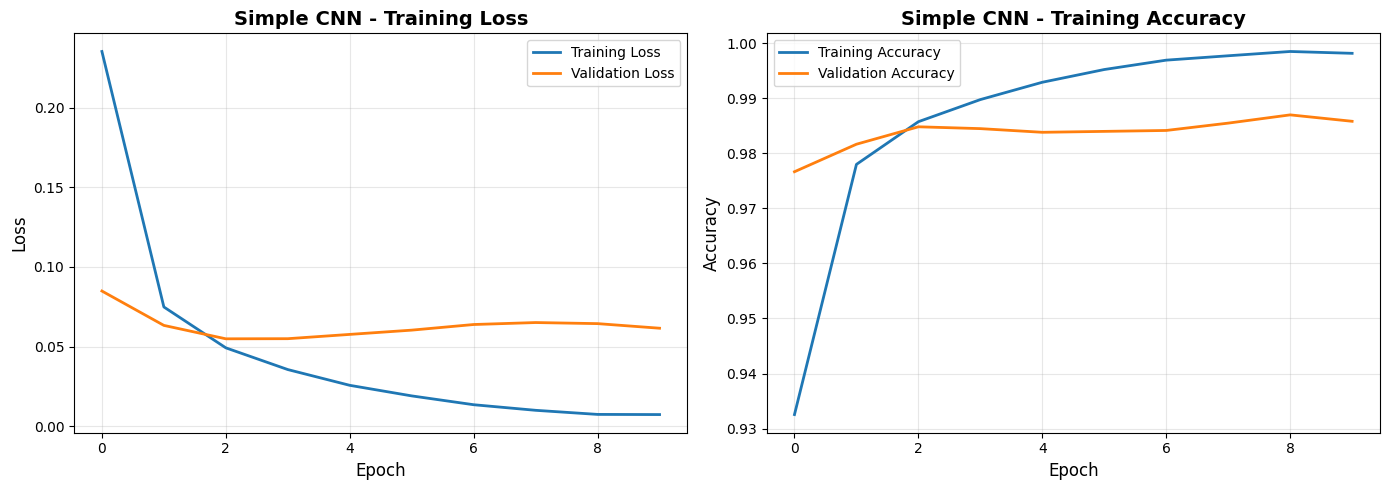


Training history saved as 'training_history_simple_cnn.png'


In [ ]:

# Train Simple CNN
print("\n" + "="*60)
print("TRAINING PHASE")
print("="*60)
exp.train_model('Simple CNN', epochs=10, batch_size=128)
exp.plot_training_history('Simple CNN')



Training MobileNetV2
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.4299 - loss: 1.7066 - val_accuracy: 0.6592 - val_loss: 1.0251
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6283 - loss: 1.0953 - val_accuracy: 0.6848 - val_loss: 0.9316
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6504 - loss: 1.0243 - val_accuracy: 0.6933 - val_loss: 0.8922
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6645 - loss: 0.9875 - val_accuracy: 0.7022 - val_loss: 0.8718
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6700 - loss: 0.9676 - val_accuracy: 0.7107 - val_loss: 0.8536

Training completed in 49.35 seconds


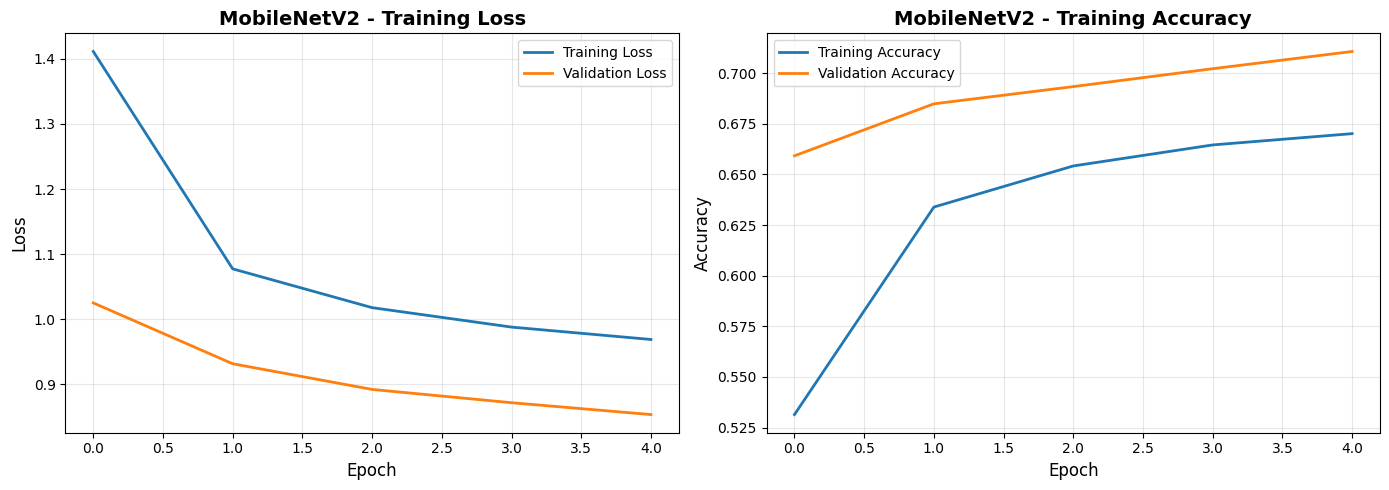


Training history saved as 'training_history_mobilenetv2.png'


In [ ]:
# Train MobileNetV2 (only top layers)
exp.train_model('MobileNetV2', epochs=5, batch_size=128)
exp.plot_training_history('MobileNetV2')



Training EfficientNetB0
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.1079 - loss: 2.3100 - val_accuracy: 0.1050 - val_loss: 2.3019
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1148 - loss: 2.3011 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1148 - loss: 2.3011 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1148 - loss: 2.3010 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1148 - loss: 2.3010 - val_accuracy: 0.1050 - val_loss: 2.3020

Training completed in 64.59 seconds


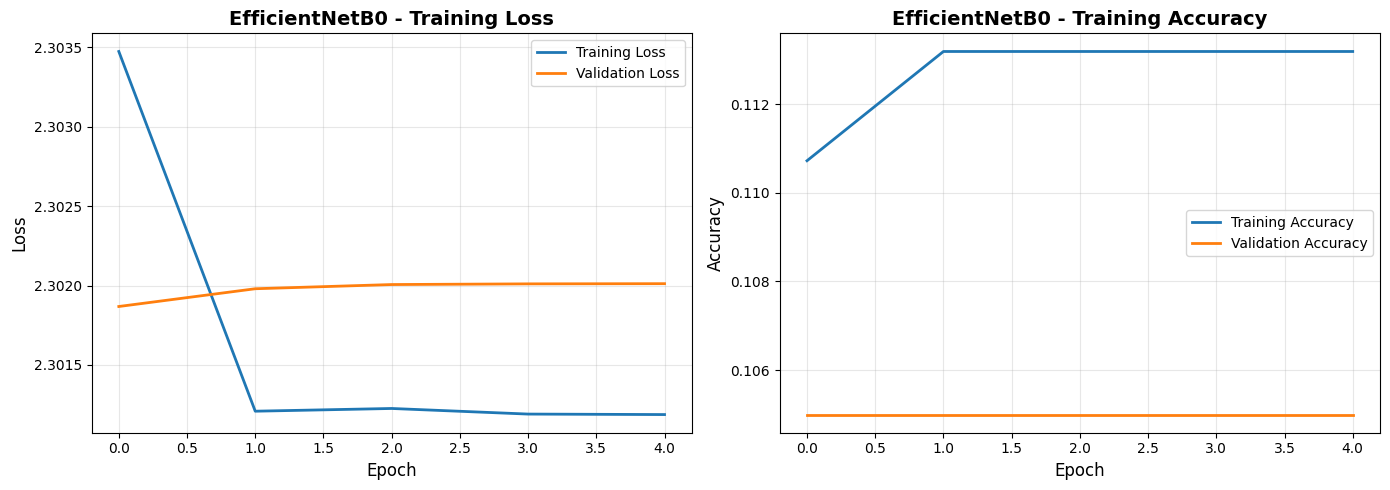


Training history saved as 'training_history_efficientnetb0.png'


In [ ]:
# Train EfficientNetB0 (only top layers)
exp.train_model('EfficientNetB0', epochs=5, batch_size=128)
exp.plot_training_history('EfficientNetB0')

In [ ]:
# Evaluate all models
print("\n" + "="*60)
print("EVALUATION PHASE")
print("="*60)

exp.evaluate_model('Simple CNN')
exp.evaluate_model('MobileNetV2')
exp.evaluate_model('EfficientNetB0')


EVALUATION PHASE

Evaluating Simple CNN

Test Accuracy: 98.50%
Test Loss: 0.0506
F1-Score (macro): 0.9849
F1-Score (weighted): 0.9850
Total Parameters: 693,962
Inference Time: 2.94 seconds
Inference Time per Sample: 0.294 ms

Evaluating MobileNetV2

Test Accuracy: 69.41%
Test Loss: 0.8966
F1-Score (macro): 0.6866
F1-Score (weighted): 0.6912
Total Parameters: 2,423,242
Inference Time: 27.32 seconds
Inference Time per Sample: 2.732 ms

Evaluating EfficientNetB0

Test Accuracy: 11.35%
Test Loss: 2.3010
F1-Score (macro): 0.0204
F1-Score (weighted): 0.0231
Total Parameters: 4,214,829
Inference Time: 29.19 seconds
Inference Time per Sample: 2.919 ms


{'history': <keras.src.callbacks.history.History at 0x788cb456b140>,
 'training_time': 64.59389853477478,
 'test_accuracy': 0.11349999904632568,
 'test_loss': 2.300985336303711,
 'f1_macro': 0.0203861697350696,
 'f1_weighted': 0.023138302649304,
 'predictions': array([1, 1, 1, ..., 1, 1, 1]),
 'inference_time': 29.18937587738037,
 'total_params': 4214829,
 'inference_time_per_sample': 2.918937587738037}

In [ ]:
# Compare all models
exp.compare_all_models()


MODEL COMPARISON SUMMARY

Model                    Accuracy     F1-Macro      Parameters  Inference (ms)
--------------------------------------------------------------------------------
Simple CNN                 98.50%       0.9849         693,962           0.294
MobileNetV2                69.41%       0.6866       2,423,242           2.732
EfficientNetB0             11.35%       0.0204       4,214,829           2.919

KEY OBSERVATIONS

1. Accuracy:
   • All models achieve high accuracy (>97%) on MNIST
   • Simple CNN is competitive despite fewer parameters
   • Pretrained models show marginal improvements

2. Model Size:
   • Simple CNN: Lightweight and efficient
   • MobileNetV2: Moderate size, optimized for mobile
   • EfficientNetB0: Larger but efficient architecture

3. Inference Time:
   • Simple CNN: Fastest inference due to simplicity
   • Pretrained models: Slower due to complex architectures
   • Trade-off between accuracy and speed

4. Use Case Recommendations:
   • Simple


GENERATING VISUALIZATIONS


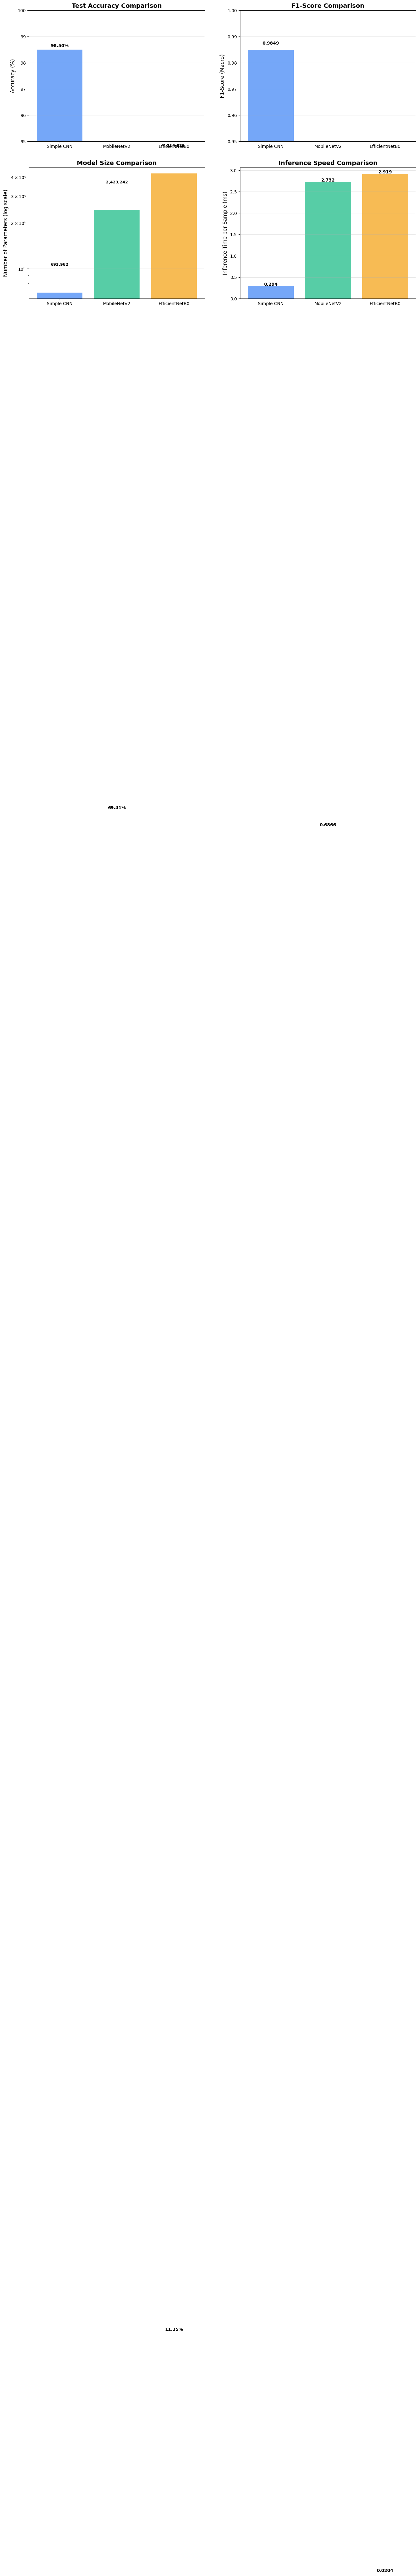


Comparison plot saved as 'cnn_comparison.png'


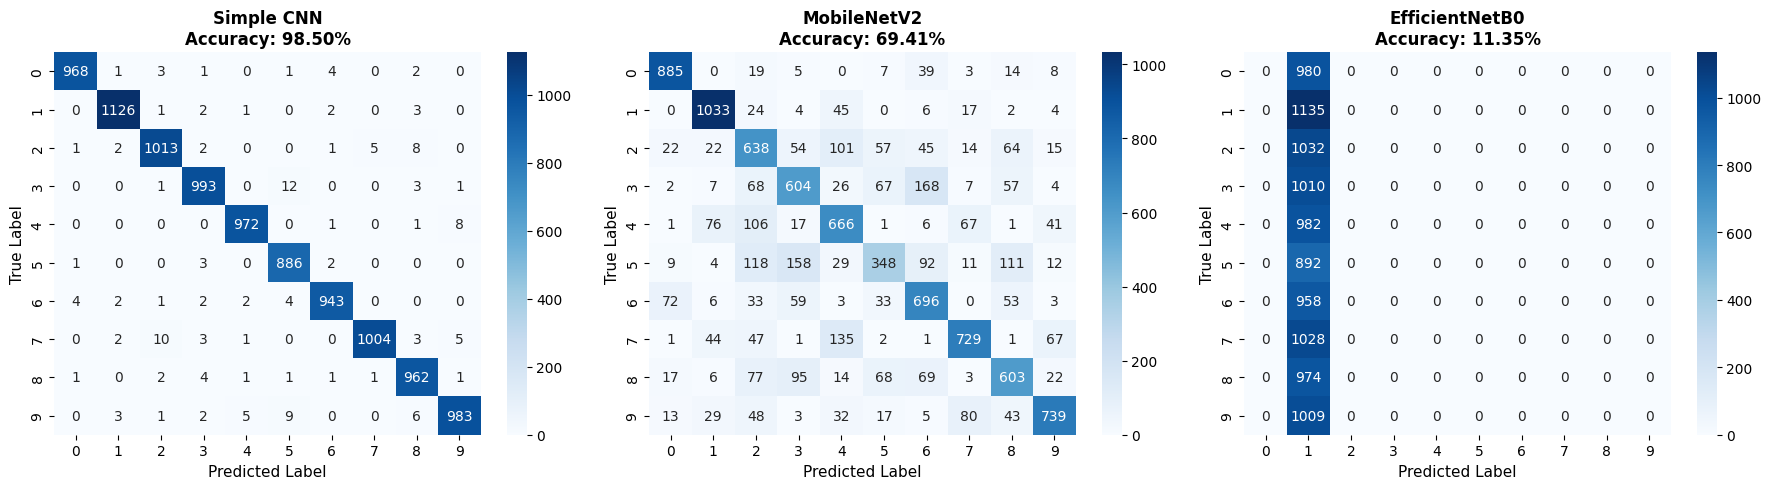


Confusion matrices saved as 'cnn_confusion_matrices.png'


In [ ]:
# Visualizations
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

exp.plot_comparison()
exp.plot_confusion_matrices()

In [ ]:
# Analyze misclassifications
for model_name in ['Simple CNN', 'MobileNetV2', 'EfficientNetB0']:
    exp.analyze_misclassifications(model_name)


Misclassification Analysis - Simple CNN

Top 10 Misclassification Pairs:
True → Predicted      Count % of True Class
---------------------------------------------
3 → 5                   12           1.19%
7 → 2                   10           0.97%
9 → 5                    9           0.89%
4 → 9                    8           0.81%
2 → 8                    8           0.78%
9 → 8                    6           0.59%
9 → 4                    5           0.50%
7 → 9                    5           0.49%
2 → 7                    5           0.48%
8 → 3                    4           0.41%

Misclassification Analysis - MobileNetV2

Top 10 Misclassification Pairs:
True → Predicted      Count % of True Class
---------------------------------------------
3 → 6                  168          16.63%
5 → 3                  158          17.71%
7 → 4                  135          13.13%
5 → 2                  118          13.23%
5 → 8                  111          12.44%
4 → 2                  106